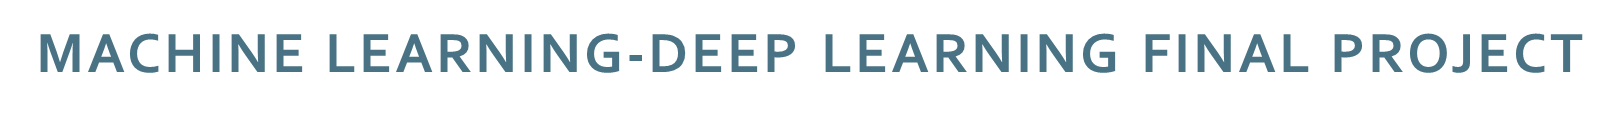
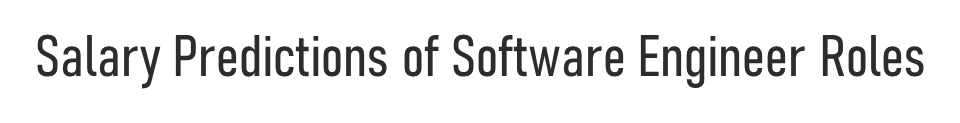

In [1]:
import pandas as pd
import re
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import wandb
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [2]:
data_path = "SoftwareEngineer_cleaned.csv"
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(34012, 12)


,title,level,company,yearsofexperience,totalyearlycompensation,gender,Doctorate_Degree,Masters_Degree,Bachelors_Degree,tag,state,city
0,Software Engineer,SE 2,eBay,5.0,100000,NaN,0,0,0,NaN,CA,San Francisco
1,Software Engineer,60,Microsoft,5.0,157000,NaN,0,0,0,NaN,CA,Mountain View
2,Software Engineer,63,Microsoft,8.5,208000,NaN,0,0,0,NaN,WA,Seattle
3,Software Engineer,62,Microsoft,4.0,156000,NaN,0,0,0,NaN,WA,Seattle
4,Software Engineer,59,Microsoft,3.0,120000,NaN,0,0,0,NaN,WA,Redmond


In [3]:
headers1 = ["company", "yearsofexperience", "Doctorate_Degree", "Masters_Degree", "Bachelors_Degree", "state", "city", "tag", "gender", 'level', "totalyearlycompensation"]
cat = ["company", "state", "city", "tag", "gender", 'level']
df_clean = df[headers1]
df_clean

,company,yearsofexperience,Doctorate_Degree,Masters_Degree,Bachelors_Degree,state,city,tag,gender,level,totalyearlycompensation
0,eBay,5.0,0,0,0,CA,San Francisco,NaN,NaN,SE 2,100000
1,Microsoft,5.0,0,0,0,CA,Mountain View,NaN,NaN,60,157000
2,Microsoft,8.5,0,0,0,WA,Seattle,NaN,NaN,63,208000
3,Microsoft,4.0,0,0,0,WA,Seattle,NaN,NaN,62,156000
4,Microsoft,3.0,0,0,0,WA,Redmond,NaN,NaN,59,120000
...,...,...,...,...,...,...,...,...,...,...,...
34007,Google,10.0,0,0,0,WA,Seattle,Distributed Systems (Back-End),NaN,T4,327000
34008,Microsoft,2.0,0,0,0,WA,Redmond,Full Stack,NaN,62,237000
34009,MSFT,14.0,0,0,0,WA,Seattle,Full Stack,NaN,63,220000
34010,Salesforce,8.0,0,0,0,CA,San Francisco,iOS,NaN,Lead MTS,280000


In [4]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse_output=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df_clean[cat]), index=df_clean.index)

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(cat)
encode_df.head()

,company_10x Genomics,company_23andMe,company_2U,company_3M,company_3m,company_7-Eleven,company_7-eleven,company_8x8,company_ABB,company_ADP,...,level_unknown,level_vice president,level_x2,level_x4,level_x5,level_x6,level_x7,level_z4,level_||,level_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_clean = df_clean.merge(encode_df,left_index=True, right_index=True)
df_clean = df_clean.drop(cat,1)
df_clean# Merge one-hot encoded features and drop the originals
df_clean

C:\Users\pedia\AppData\Local\Temp\ipykernel_21080\1232695819.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_clean = df_clean.drop(cat,1)


,yearsofexperience,Doctorate_Degree,Masters_Degree,Bachelors_Degree,totalyearlycompensation,company_10x Genomics,company_23andMe,company_2U,company_3M,company_3m,...,level_unknown,level_vice president,level_x2,level_x4,level_x5,level_x6,level_x7,level_z4,level_||,level_nan
0,5.0,0,0,0,100000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0,0,0,157000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.5,0,0,0,208000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0,0,0,156000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0,0,0,120000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34007,10.0,0,0,0,327000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34008,2.0,0,0,0,237000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34009,14.0,0,0,0,220000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34010,8.0,0,0,0,280000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Split our preprocessed data into our features and target arrays
y = df_clean.totalyearlycompensation
X = df_clean.drop(columns=["totalyearlycompensation"])

In [7]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, train_size=0.8)

In [8]:
X_train = torch.from_numpy(X_train.values).float()
y_train = torch.from_numpy(y_train.values).float()
X_test = torch.from_numpy(X_test.values).float()
y_test = torch.from_numpy(y_test.values).float()

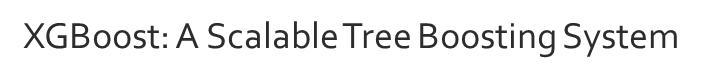
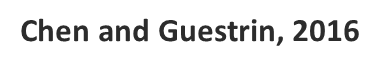

In [9]:
xgb = XGBRegressor(n_estimators=200, max_depth=9, eta=0.175, subsample=0.6, colsample_bytree=0.85) 
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=["mae"], verbose=False)

results = xgb.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)



C:\Users\pedia\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


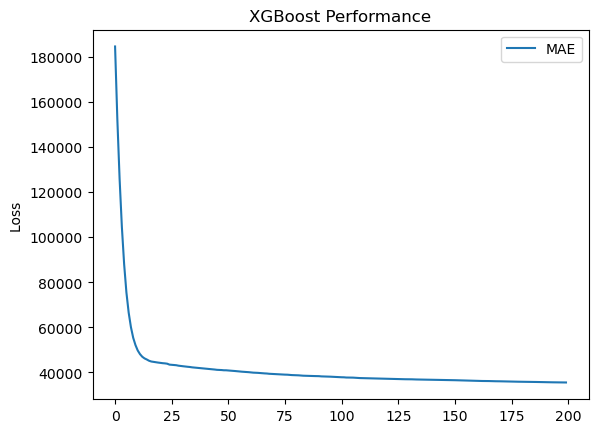

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='MAE')

ax.legend()
plt.ylabel('Loss')
plt.title('XGBoost Performance')
plt.show()

In [11]:
Y_pred = xgb.predict(X_test)
training_score = xgb.score(X_train, y_train)
testing_score = xgb.score(X_test, y_test)
mse = mean_absolute_percentage_error(y_test, Y_pred)
print(f"Mean absolute percentage error: {mse}")
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Mean absolute percentage error: 0.16624751687049866
Training Score: 0.8674901089233629
Testing Score: 0.7581048016586882


In [12]:
pred = pd.DataFrame({"Prediction": Y_pred, "Actual": y_test})
pred.reset_index(drop=True, inplace=True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
pred

,Prediction,Actual
0,254511.390625,270000.0
1,387949.281250,395000.0
2,214197.093750,227000.0
3,157161.437500,250000.0
4,224678.640625,175000.0
5,160615.234375,130000.0
6,154812.781250,172000.0
7,221982.734375,190000.0
8,178614.984375,201000.0
9,363864.687500,439000.0


In [13]:
r2 = r2_score(Y_pred, y_test)
print("R-squared score: ", r2)

R-squared score:  0.6606605279314912


## Finally i achieved R2 Score 66%

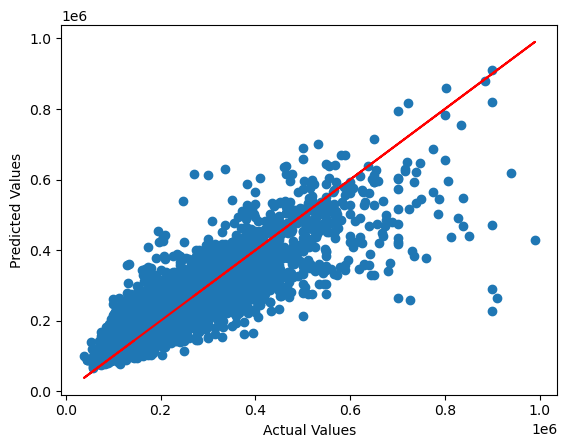

In [14]:
import matplotlib.pyplot as plt

plt.scatter(y_test, Y_pred)

# Add a line of best fit
plt.plot(y_test, y_test, color = 'red')

# Add axis labels
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Show the plot
plt.show()